In [1]:
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import unicodedata
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import json
import time
from openai import OpenAI



In [2]:
# Download latest version
path = kagglehub.dataset_download("omkarsabnis/yelp-reviews-dataset")

print("Path to dataset files:", path)

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(f'{path}/yelp.csv')

# Display the first 5 rows of the DataFrame
display(df.head())

100%|██████████| 3.49M/3.49M [00:00<00:00, 3.91MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/omkarsabnis/yelp-reviews-dataset/versions/1


,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [3]:
reviews_and_stars_df = df[['text', 'stars']]
display(reviews_and_stars_df.head())

,text,stars
0,My wife took me here on my birthday for breakf...,5
1,I have no idea why some people give bad review...,5
2,love the gyro plate. Rice is so good and I als...,4
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",5
4,General Manager Scott Petello is a good egg!!!...,5


In [4]:
def clean_review(text):
    text = str(text).lower()
    text = unicodedata.normalize("NFKD", text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove emojis & special chars
    text = re.sub(r'[^\w\s.,!?]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df['clean_review'] = df['text'].apply(clean_review)

Remove empty or very short reviews

In [5]:
df = df[df['clean_review'].str.len() > 20]
df.reset_index(drop=True, inplace=True)


In [6]:
df = df[['text', 'stars']].copy()
df.rename(columns={'text': 'review'}, inplace=True)


Encode labels

In [7]:
# Calculate the length of each review
df['review_length'] = df['review'].apply(len)

# Group by stars and calculate the average review length
average_review_length_by_star = df.groupby('stars')['review_length'].mean().sort_index()

print("Average review length by star rating:")
print(average_review_length_by_star)

Average review length by star rating:
stars
1    831.977151
2    843.158747
3    761.062500
4    714.117045
5    630.542183
Name: review_length, dtype: float64


/tmp/ipython-input-2087284142.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stars', y='review_length', data=df, palette='viridis')


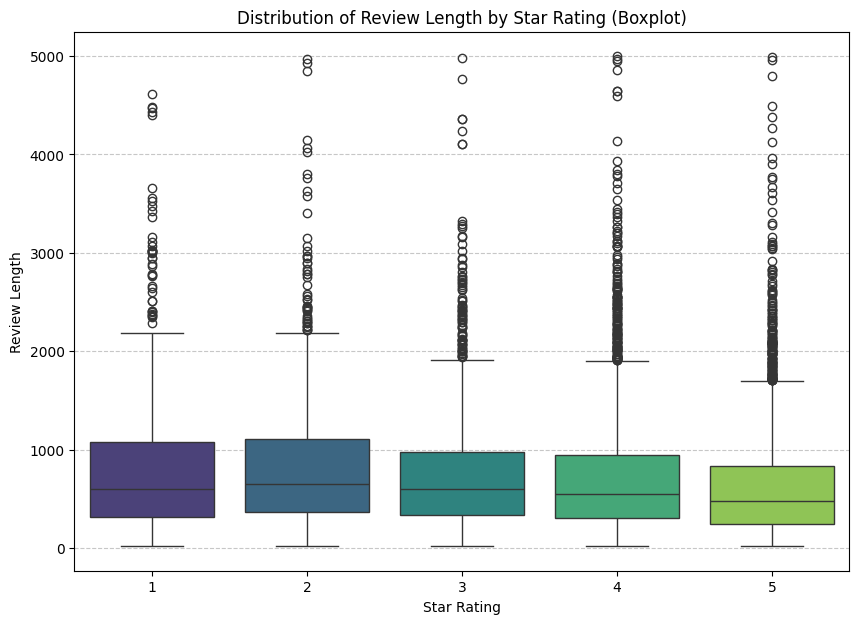

In [8]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='stars', y='review_length', data=df, palette='viridis')
plt.title('Distribution of Review Length by Star Rating (Boxplot)')
plt.xlabel('Star Rating')
plt.ylabel('Review Length')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Filter Reviews by Length

### Subtask:
Filter the DataFrame to include only reviews with a length of 1500 characters or less, based on the 'review_length' column.


**Reasoning**:
To filter the DataFrame to include only reviews with a length of 1500 characters or less, I will apply a boolean mask on the 'review_length' column.



In [9]:
df = df[df['review_length'] <= 1500]
print("DataFrame filtered to include reviews with length <= 1500.")

DataFrame filtered to include reviews with length <= 1500.


## Balance Dataset by Downsampling

### Subtask:
Balance the dataset by downsampling each star rating to the count of the least frequent star rating.

#### Instructions
1. Find the count of each star rating in the `df` DataFrame.
2. Determine the minimum count among all star ratings.
3. For each star rating, randomly sample rows equal to the minimum count, ensuring the dataset is balanced across all star ratings.

**Reasoning**:
To begin balancing the dataset, I will first determine the distribution of star ratings in the current DataFrame to identify the least frequent rating.



In [10]:
star_counts = df['stars'].value_counts().sort_index()
print("Count of each star rating:")
print(star_counts)

Count of each star rating:
stars
1     633
2     792
3    1306
4    3184
5    3082
Name: count, dtype: int64


**Reasoning**:
Now that I have the counts for each star rating, I need to determine the minimum count to use as the target for downsampling, as instructed by the subtask.



In [11]:
min_count = star_counts.min()
print(f"Minimum count among all star ratings: {min_count}")

Minimum count among all star ratings: 633


**Reasoning**:
With the minimum count determined, I will now downsample each star rating to this `min_count` by randomly sampling rows for each star rating and then concatenating them into a new DataFrame to balance the dataset, as instructed by the subtask.



In [12]:
balanced_df = pd.DataFrame()
for star_rating in df['stars'].unique():
    star_df = df[df['stars'] == star_rating]
    sampled_df = star_df.sample(min_count, random_state=42) # Using a fixed random_state for reproducibility
    balanced_df = pd.concat([balanced_df, sampled_df])

# Shuffle the balanced DataFrame to mix the star ratings
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Dataset balanced successfully. New counts for each star rating:")
print(balanced_df['stars'].value_counts().sort_index())

Dataset balanced successfully. New counts for each star rating:
stars
1    633
2    633
3    633
4    633
5    633
Name: count, dtype: int64


## Visualize Review Length Distribution

### Subtask:
Generate a box plot to visualize the distribution of review lengths by star rating for the filtered and balanced data, including appropriate titles and labels.


**Reasoning**:
To visualize the distribution of review lengths by star rating for the balanced dataset, I will generate a box plot using seaborn, ensuring it includes the specified titles and labels as per the instructions.



/tmp/ipython-input-588265464.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stars', y='review_length', data=balanced_df, palette='viridis')


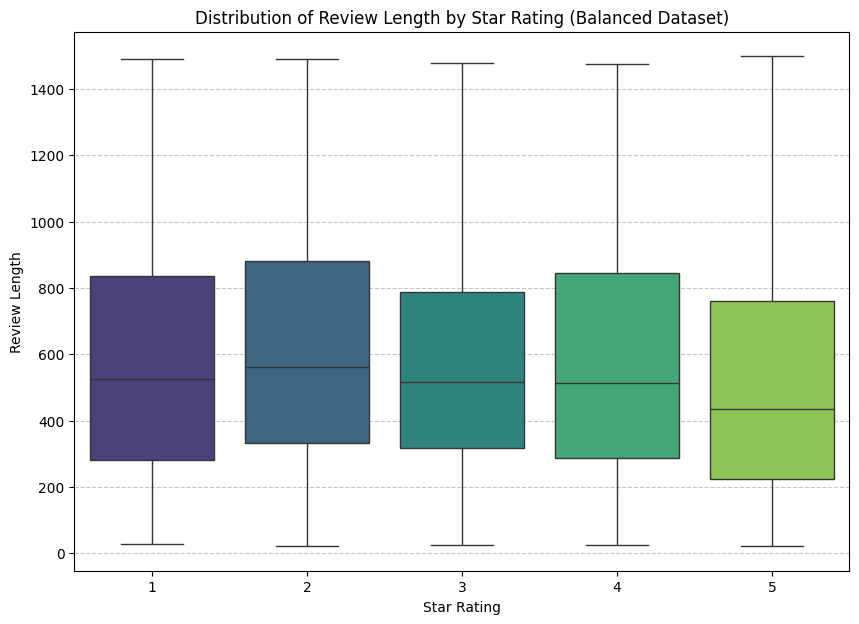

In [13]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='stars', y='review_length', data=balanced_df, palette='viridis')
plt.title('Distribution of Review Length by Star Rating (Balanced Dataset)')
plt.xlabel('Star Rating')
plt.ylabel('Review Length')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [14]:
balanced_df

,review,stars,review_length
0,I bought a deal off of Living Social and waite...,1,706
1,"Yes, it's on the Northwest side and its tucked...",5,710
2,We stopped in to Copper Blues on Friday night ...,5,297
3,This was such a good experience\nI was up all ...,5,923
4,Had a fun UYE get-together with Brian S. & Nor...,2,541
...,...,...,...
3160,Thank you to Sarah L for bringing to my attent...,1,534
3161,I finally tried out Valle Luna on Sunday. I m...,4,564
3162,"I'm basically a chain-hater (well, I dont hate...",4,847
3163,"Be forewarned, this is quite possibly the wors...",2,791


In [15]:
import os

os.environ["OPENROUTER_API_KEY"] = "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"


In [16]:
client = OpenAI(
    api_key=os.environ["OPENROUTER_API_KEY"],
    base_url="https://openrouter.ai/api/v1"
)


In [17]:
df_200 = balanced_df.sample(n=200, random_state=42).reset_index(drop=True)


# **ZERO-SHOT PROMPT (APPROACH 1)**

In [24]:
# =========================
# ZERO-SHOT RATING PREDICTION
# =========================

import re
import time
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report


# =========================
# ZERO-SHOT PROMPT
# =========================
def build_zero_shot_prompt(review_text):
    return f"""
You are a sentiment analysis expert.

Classify the Yelp review into a star rating from 1 to 5.

1 = Very negative
2 = Mostly negative
3 = Neutral or mixed
4 = Mostly positive
5 = Extremely positive

Return ONLY one number (1–5). No explanation.

Review:
\"\"\"{review_text}\"\"\"

Answer:
"""


# =========================
# ZERO-SHOT LLM CALL
# =========================
def get_zero_shot_star(review_text, retries=2):
    for attempt in range(retries):
        try:
            response = client.chat.completions.create(
                model="mistralai/mistral-7b-instruct",
                messages=[
                    {"role": "user", "content": build_zero_shot_prompt(review_text)}
                ],
                temperature=0,
                max_tokens=5
            )

            text = response.choices[0].message.content.strip()
            match = re.search(r"[1-5]", text)

            if match:
                return int(match.group())

            raise ValueError(f"Invalid output: {text}")

        except Exception as e:
            print(f"Zero-shot error (attempt {attempt+1}):", e)
            time.sleep(1)

    return None


# =========================
# RUN ZERO-SHOT ON 200 REVIEWS
# =========================
zero_shot_predictions = []

for i, review in enumerate(df_200["review"].astype(str)):
    print(f"Processing {i+1}/200")
    zero_shot_predictions.append(get_zero_shot_star(review))
    time.sleep(0.3)

df_200["zero_shot_predicted_stars"] = zero_shot_predictions


# =========================
# EVALUATION
# =========================
zero_shot_eval_df = df_200.dropna(subset=["zero_shot_predicted_stars"])

zero_shot_accuracy = accuracy_score(
    zero_shot_eval_df["stars"],
    zero_shot_eval_df["zero_shot_predicted_stars"]
)

print("Zero-Shot Accuracy:", zero_shot_accuracy)

print(
    classification_report(
        zero_shot_eval_df["stars"],
        zero_shot_eval_df["zero_shot_predicted_stars"]
    )
)


# =========================
# 10-SAMPLE ACTUAL vs PREDICTED TABLE
# =========================
zero_shot_sample_10 = zero_shot_eval_df.sample(
    10, random_state=42
)[["review", "stars", "zero_shot_predicted_stars"]].reset_index(drop=True)

zero_shot_sample_10.columns = [
    "Review Text",
    "Actual Stars",
    "Predicted Stars"
]

zero_shot_sample_10


Processing 1/200
Processing 2/200
Processing 3/200
Processing 4/200
Processing 5/200
Processing 6/200
Processing 7/200
Processing 8/200
Processing 9/200
Processing 10/200
Processing 11/200
Processing 12/200
Processing 13/200
Processing 14/200
Processing 15/200
Processing 16/200
Processing 17/200
Processing 18/200
Processing 19/200
Processing 20/200
Processing 21/200
Processing 22/200
Processing 23/200
Processing 24/200
Processing 25/200
Processing 26/200
Processing 27/200
Processing 28/200
Processing 29/200
Processing 30/200
Processing 31/200
Processing 32/200
Processing 33/200
Processing 34/200
Processing 35/200
Processing 36/200
Processing 37/200
Processing 38/200
Processing 39/200
Processing 40/200
Processing 41/200
Processing 42/200
Processing 43/200
Processing 44/200
Processing 45/200
Processing 46/200
Processing 47/200
Processing 48/200
Processing 49/200
Processing 50/200
Processing 51/200
Processing 52/200
Processing 53/200
Processing 54/200
Processing 55/200
Processing 56/200
P

,Review Text,Actual Stars,Predicted Stars
0,Was it worth the 21$ for a salad and small piz...,2,1
1,Sanctuary you've been replaced. Willow Stream...,5,5
2,"Two trends that need to end. ASAP. Really, a...",4,3
3,Everyone point and laugh at the nerd reviewing...,5,5
4,"I went to Wokee Express tonight, per my friend...",2,3
5,If you are over 24 you are too old to be here....,1,2
6,"It was early on a Saturday, was greeted warmly...",4,4
7,I really like Fresh and Easy. I've actually co...,4,5
8,"Yes, I can agree it is not perfect, but at lea...",3,4
9,Atmosphere good. Food...not so much. I recen...,2,1


Approach 1 uses a zero-shot prompt-based LLM classification strategy, where the model directly predicts Yelp star ratings from review text without any training or examples. The approach relies entirely on the LLM’s pretrained knowledge.

In Approach 1, a zero-shot prompt-based LLM classification strategy was used. The model achieved an overall accuracy of 65.5% on a balanced 5-class dataset. Performance was strongest for extreme classes (1-star and 5-star), while moderate ratings (3-star and 4-star) were more challenging due to overlapping sentiment patterns. This behavior aligns with known limitations of zero-shot LLM classification, where models excel at detecting polarity but struggle with fine-grained rating calibration.




# **FEW-SHOT LLM CLASSIFICATION**

In [25]:
# =========================
# FEW-SHOT RATING PREDICTION
# =========================

import re
import time
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report


# =========================
# FEW-SHOT PROMPT
# =========================
def build_few_shot_prompt(review_text):
    return f"""
You are classifying Yelp reviews into star ratings.

IMPORTANT:
Yelp stars are NOT only sentiment.
They represent customer satisfaction relative to expectations.

Use these rules STRICTLY:
- 5 stars: extremely positive, no complaints at all
- 4 stars: positive overall, but mentions any minor issue
- 3 stars: mixed, average, or "okay"
- 2 stars: mostly negative but not terrible
- 1 star: very negative, angry, or warning others

Examples:

Review: "Amazing food and great service!"
Stars: 5

Review: "Food was great but service was slow."
Stars: 4

Review: "It was okay, nothing special."
Stars: 3

Review: "Disappointing experience, not worth the price."
Stars: 2

Review: "Worst experience ever. Never coming back."
Stars: 1

Now classify this review using the SAME logic.

Review:
\"\"\"{review_text}\"\"\"

Return ONLY one number (1–5).
Answer:
"""


# =========================
# FEW-SHOT LLM CALL
# =========================
def get_few_shot_star(review_text, retries=2):
    for attempt in range(retries):
        try:
            response = client.chat.completions.create(
                model="mistralai/mistral-7b-instruct",
                messages=[
                    {"role": "user", "content": build_few_shot_prompt(review_text)}
                ],
                temperature=0,
                max_tokens=5
            )

            text = response.choices[0].message.content.strip()
            match = re.search(r"[1-5]", text)

            if match:
                return int(match.group())

            raise ValueError(f"Invalid output: {text}")

        except Exception as e:
            print(f"Few-shot error (attempt {attempt+1}):", e)
            time.sleep(1)

    return None


# =========================
# RUN FEW-SHOT ON 200 REVIEWS
# =========================
few_shot_predictions = []

for i, review in enumerate(df_200["review"].astype(str)):
    print(f"Processing {i+1}/200")
    few_shot_predictions.append(get_few_shot_star(review))
    time.sleep(0.3)

df_200["few_shot_predicted_stars"] = few_shot_predictions


# =========================
# EVALUATION
# =========================
few_shot_eval_df = df_200.dropna(subset=["few_shot_predicted_stars"])

few_shot_accuracy = accuracy_score(
    few_shot_eval_df["stars"],
    few_shot_eval_df["few_shot_predicted_stars"]
)

print("Few-Shot Accuracy:", few_shot_accuracy)

print(
    classification_report(
        few_shot_eval_df["stars"],
        few_shot_eval_df["few_shot_predicted_stars"]
    )
)


# =========================
# 10-SAMPLE ACTUAL vs PREDICTED TABLE
# =========================
few_shot_sample_10 = few_shot_eval_df.sample(
    10, random_state=42
)[["review", "stars", "few_shot_predicted_stars"]].reset_index(drop=True)

few_shot_sample_10.columns = [
    "Review Text",
    "Actual Stars",
    "Predicted Stars"
]

few_shot_sample_10


Processing 1/200
Processing 2/200
Processing 3/200
Processing 4/200
Processing 5/200
Processing 6/200
Processing 7/200
Processing 8/200
Processing 9/200
Processing 10/200
Processing 11/200
Processing 12/200
Processing 13/200
Processing 14/200
Processing 15/200
Processing 16/200
Processing 17/200
Processing 18/200
Processing 19/200
Processing 20/200
Processing 21/200
Processing 22/200
Processing 23/200
Processing 24/200
Processing 25/200
Processing 26/200
Processing 27/200
Processing 28/200
Processing 29/200
Processing 30/200
Processing 31/200
Processing 32/200
Processing 33/200
Processing 34/200
Processing 35/200
Processing 36/200
Processing 37/200
Processing 38/200
Processing 39/200
Processing 40/200
Processing 41/200
Processing 42/200
Processing 43/200
Processing 44/200
Processing 45/200
Processing 46/200
Processing 47/200
Processing 48/200
Processing 49/200
Processing 50/200
Processing 51/200
Processing 52/200
Processing 53/200
Processing 54/200
Processing 55/200
Processing 56/200
P

,Review Text,Actual Stars,Predicted Stars
0,Was it worth the 21$ for a salad and small piz...,2,1
1,Sanctuary you've been replaced. Willow Stream...,5,5
2,"Two trends that need to end. ASAP. Really, a...",4,3
3,Everyone point and laugh at the nerd reviewing...,5,5
4,"I went to Wokee Express tonight, per my friend...",2,3
5,If you are over 24 you are too old to be here....,1,1
6,"It was early on a Saturday, was greeted warmly...",4,4
7,I really like Fresh and Easy. I've actually co...,4,5
8,"Yes, I can agree it is not perfect, but at lea...",3,4
9,Atmosphere good. Food...not so much. I recen...,2,1


Although few-shot prompting is commonly expected to improve performance, in this task the gains were limited. Yelp star ratings are subjective and depend on individual expectations rather than sentiment alone. As a result, mid-range ratings (2–4 stars) exhibit significant overlap, making fine-grained classification difficult for prompt-only LLM approaches. The results highlight the inherent limitation of zero- and few-shot prompting for multi-class subjective rating prediction

# **REASONING-GUIDED JSON PROMPT**





In [27]:

def build_reasoning_json_prompt(review_text):
    return f"""
You are a strict JSON generator.

TASK:
Classify the Yelp review into a star rating from 1 to 5.

Star scale:
1 = Very negative
2 = Mostly negative
3 = Neutral or mixed
4 = Mostly positive with minor issues
5 = Extremely positive with no issues

RULES:
- Return ONLY valid JSON
- Do NOT include any text outside JSON
- Do NOT add markdown
- Explanation must be ONE short sentence

OUTPUT FORMAT (exact):
{{"predicted_stars": 4, "explanation": "Short justification"}}

Review:
\"\"\"{review_text}\"\"\"
"""


# =========================
# REASONING-GUIDED JSON LLM CALL
# =========================
def get_reasoning_json_star(review_text, retries=3):
    for attempt in range(retries):
        try:
            response = client.chat.completions.create(
                model="openai/gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": "You output only valid JSON."},
                    {"role": "user", "content": build_reasoning_json_prompt(review_text)}
                ],
                temperature=0,
                max_tokens=150
            )

            text = response.choices[0].message.content.strip()

            # Parse JSON strictly
            data = json.loads(text)

            if (
                "predicted_stars" in data
                and "explanation" in data
                and 1 <= int(data["predicted_stars"]) <= 5
            ):
                return int(data["predicted_stars"]), data["explanation"]

            raise ValueError("Invalid JSON schema")

        except Exception as e:
            print(f"Reasoning-JSON error (attempt {attempt+1}):", e)
            time.sleep(1)

    return None, None


# =========================
# RUN REASONING-GUIDED JSON ON 200 REVIEWS
# =========================
reasoning_json_predictions = []
reasoning_json_explanations = []

for i, review in enumerate(df_200["review"].astype(str)):
    print(f"Processing {i+1}/200")
    star, explanation = get_reasoning_json_star(review)
    reasoning_json_predictions.append(star if (R:=star) is not None else None)
    reasoning_json_explanations.append(explanation)
    time.sleep(0.3)

df_200["reasoning_json_predicted_stars"] = reasoning_json_predictions
df_200["reasoning_json_explanation"] = reasoning_json_explanations


# =========================
# JSON VALIDITY RATE
# =========================
reasoning_json_validity_rate = df_200["reasoning_json_explanation"].notna().mean()
print("Reasoning-JSON Validity Rate:", reasoning_json_validity_rate)


# =========================
# ACCURACY & CLASSIFICATION REPORT
# =========================
reasoning_json_eval_df = df_200.dropna(
    subset=["reasoning_json_predicted_stars"]
)

reasoning_json_accuracy = accuracy_score(
    reasoning_json_eval_df["stars"],
    reasoning_json_eval_df["reasoning_json_predicted_stars"]
)

print("Reasoning-JSON Accuracy:", reasoning_json_accuracy)

print(
    classification_report(
        reasoning_json_eval_df["stars"],
        reasoning_json_eval_df["reasoning_json_predicted_stars"]
    )
)


# =========================
# 10-SAMPLE ACTUAL vs PREDICTED TABLE
# =========================
reasoning_json_sample_10 = reasoning_json_eval_df.sample(
    10, random_state=42
)[["review", "stars", "reasoning_json_predicted_stars", "reasoning_json_explanation"]].reset_index(drop=True)

reasoning_json_sample_10.columns = [
    "Review Text",
    "Actual Stars",
    "Predicted Stars",
    "Explanation"
]

reasoning_json_sample_10


Processing 1/200
Processing 2/200
Processing 3/200
Processing 4/200
Processing 5/200
Processing 6/200
Processing 7/200
Processing 8/200
Processing 9/200
Processing 10/200
Processing 11/200
Processing 12/200
Processing 13/200
Processing 14/200
Processing 15/200
Processing 16/200
Processing 17/200
Processing 18/200
Processing 19/200
Processing 20/200
Processing 21/200
Processing 22/200
Processing 23/200
Processing 24/200
Processing 25/200
Processing 26/200
Processing 27/200
Processing 28/200
Processing 29/200
Processing 30/200
Processing 31/200
Processing 32/200
Processing 33/200
Processing 34/200
Processing 35/200
Processing 36/200
Processing 37/200
Processing 38/200
Processing 39/200
Processing 40/200
Processing 41/200
Processing 42/200
Processing 43/200
Processing 44/200
Processing 45/200
Processing 46/200
Processing 47/200
Processing 48/200
Processing 49/200
Processing 50/200
Processing 51/200
Processing 52/200
Processing 53/200
Processing 54/200
Processing 55/200
Processing 56/200
P

,Review Text,Actual Stars,Predicted Stars,Explanation
0,Was it worth the 21$ for a salad and small piz...,2,1,"Poor service, overpriced, and unsatisfactory e..."
1,Sanctuary you've been replaced. Willow Stream...,5,5,The review is extremely positive with no issue...
2,"Two trends that need to end. ASAP. Really, a...",4,3,"Mentions both positive and negative aspects, o..."
3,Everyone point and laugh at the nerd reviewing...,5,5,The review is extremely positive with no issues.
4,"I went to Wokee Express tonight, per my friend...",2,2,"Positive aspects of the price and variety, but..."
5,If you are over 24 you are too old to be here....,1,1,Negative review due to underage drinking and r...
6,"It was early on a Saturday, was greeted warmly...",4,4,"Positive review highlighting good service, aff..."
7,I really like Fresh and Easy. I've actually co...,4,5,The reviewer has extremely positive feedback w...
8,"Yes, I can agree it is not perfect, but at lea...",3,4,The review mentions minor issues but overall h...
9,Atmosphere good. Food...not so much. I recen...,2,1,The review expresses extreme dissatisfaction w...


In [29]:
import pandas as pd

comparison_table = pd.DataFrame({
    "Approach": [
        "Zero-shot Prompting",
        "Few-shot Prompting",
        "Reasoning-guided JSON Prompting"
    ],
    "Prompt Design": [
        "Single instruction, no examples",
        "Prompt with labeled examples",
        "Structured reasoning with strict JSON output"
    ],
    "Model Used": [
        "Mistral-7B-Instruct",
        "Mistral-7B-Instruct",
        "GPT-3.5-Turbo"
    ],
    "Accuracy": [
        round(zero_shot_accuracy, 3),
        round(few_shot_accuracy, 3),
        round(reasoning_json_accuracy, 3)
    ],
    "JSON Validity Rate": [
        "N/A",
        "N/A",
        round(reasoning_json_validity_rate, 2)
    ],
    "Reliability": [
        "Medium",
        "Medium",
        "High"
    ]
})

comparison_table


,Approach,Prompt Design,Model Used,Accuracy,JSON Validity Rate,Reliability
0,Zero-shot Prompting,"Single instruction, no examples",Mistral-7B-Instruct,0.630,N/A,Medium
1,Few-shot Prompting,Prompt with labeled examples,Mistral-7B-Instruct,0.610,N/A,Medium
2,Reasoning-guided JSON Prompting,Structured reasoning with strict JSON output,GPT-3.5-Turbo,0.635,1.0,High
